In [1]:
import numpy as np
import os
import sys

import torch
from torch import nn
from torchsummary import summary

import importlib

import matplotlib.pyplot as plt

sys.path.insert(0, "../src/")
import data
import model
import train

import nmrglue as ng

np.random.seed(123)

In [2]:
mod = "Ensemble_PIPNet_2021_10_14_lin"

in_dir = f"../data/{mod}/"
fig_dir = f"../figures/{mod}/"

load_model = True

eval_history = True

n_samples = 16

eval_evolution = True

eval_sparse = True

eval_noise = True
noise_levels = [1e-5, 1e-4, 1e-3]

eval_exp = True
exp_dir = f"../data/experimental_spectra/topspin/"
exp_compounds = ["ampicillin", "aspala", "flutamide", "histidine", "thymol", "tyrosine"]


data_pars = dict(
                 # General parameters
                 td = 512, # Number of points
                 Fs = 10, # Sampling frequency
                 debug = False, # Print data generation details

                 # Peak parameters
                 pmin = 1, # Minimum number of Gaussians in a peak
                 pmax = 10, # Maximum number of Gaussians in a peak
                 ds = 0.03, # Spread of chemical shift values for each peak
                 lw = [1e-2, 1e-1], # Linewidth range for Gaussians
                 phase = 0., # Spread of phase

                 # Isotropic parameters
                 nmin = 1, # Minimum number of peaks
                 nmax = 10, # Maximum number of peaks
                 shift_range = [1., 9.], # Chemical shift range
                 positive = True, # Force the spectrum to be positive

                 # MAS-dependent parameters
                 mas_g_range = [1e4, 1e5], # MAS-dependent Gaussian broadening range
                 mas_l_range = [1e4, 1e5], # MAS-dependent Lorentzian broadening range
                 mas_s_range = [-1e4, 1e4], # MAS-dependent shift range
                 mas_phase = 0.1, # Random phase range for MAS spectra
                 peakwise_phase = True, # Whether the phase should be peak-wise or spectrum-wise
                 encode_imag = False, # Encode the imaginary part of the MAS spectra
                 nw = 8, # Number of MAS rates
                 mas_w_range = [30000, 100000], # MAS rate range
                 random_mas = False,
                 encode_w = False, # Encode the MAS rate of the spectra

                 # Post-processing parameters
                 noise = 0., # Noise level
                 smooth_end_len = 10, # Smooth ends of spectra
                 scale_iso = 0.8, # Scale isotropic spectra
                 offset = 0., # Baseline offset
                 norm_wr = True, # Normalize MAS rate values
                 wr_inv = False # Encode inverse of MAS rate instead of MAS rate
                )

dataset = data.PIPDataset(**data_pars)

In [76]:
def load_topspin_spectrum(d):
    
    pd = f"{d}pdata/1/"
    
    fr = pd + "1r"
    fi = pd + "1i"
    
    try:

        with open(fr, "rb") as F:
            dr = np.fromfile(F, np.int32).astype(float)

        with open(fi, "rb") as F:
            di = np.fromfile(F, np.int32).astype(float)

    except:
        dr = np.array([])
        di = np.array([])
    
    return dr, di

In [71]:
exp_mas = []
exp_trg = []

for compound in exp_compounds:
    
    comp_mas = []
    
    d = f"{exp_dir}{compound}/"
    
    i0 = -1
    n_exp = 0
    ds = os.listdir(d)
    for di in ds:
        if os.path.isdir(d + di):
            i = int(di)
            n_exp = max(n_exp, i)
            
            if i0 == -1 or i < i0:
                i0 = i
    
    print(compound)
    print(i0, n_exp)
    
    l = -1
    
    for i in range(i0, n_exp):
        Xr, Xi = load_topspin_spectrum(f"{d}{i+1}/")
        
        if l == -1 and Xr.shape[0] > 0:
            l = Xr.shape[0]
        
        if Xr.shape[0] == l:
            
        comp_mas.append(Xr)

    exp_mas.append(np.array(comp_mas))

ampicillin
1 41
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
aspala
100 137
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
16384
flutamide
1 41
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
histidine
1 41
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
4096
thymol
1 41
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2

<ipython-input-71-5ffe471eb92a>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  exp_mas.append(np.array(comp_mas))


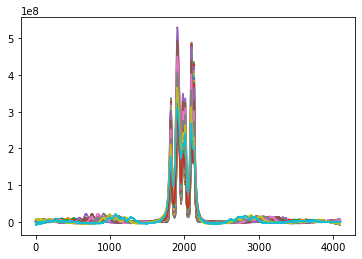

ValueError: setting an array element with a sequence.

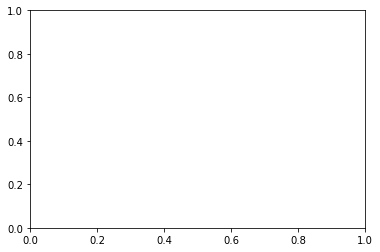

In [72]:
for exp in exp_mas:
    plt.plot(exp.T)
    plt.show()
    plt.close()

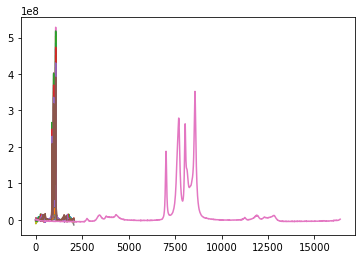

In [73]:
for e in exp:
    plt.plot(e)

In [52]:
len(exp_mas)

6

# JCAMP-DX (issue: only contains FID)

In [10]:
exp_mas = []
exp_trg = []

for compound in exp_compounds:
    
    comp_mas = []
    
    d = exp_dir + compound + "_jcamp/"
    
    n_exp = 0
    fs = os.listdir(d)
    for f in fs:
        if f.endswith(".dx"):
            n_exp = max(n_exp, int(f.split("_")[-1].split(".")[0]))
    
    for i in range(n_exp):
        for f in fs:
            if f.endswith(f"_{i+1}.dx"):
                params, fid = ng.jcampdx.read(d + f)
            
    break

In [11]:
params

{'_comments': ['Bruker NMR JCAMP-DX V2.0',
  '1.109 TopSpin 4.0.6',
  '2021-06-23 18:44:43.919 +0200  moutzour@lrmb100963',
  'Compression mode = diff/dup',
  '(NUMBER, WHEN, WHO, WHERE, PROCESS, VERSION, WHAT)',
  '##TITLE= Audit trail, TopSpin 4.0.9',
  '##JCAMPDX= 5.01',
  '##ORIGIN= Bruker BioSpin GmbH',
  '##OWNER= root',
  '$$ /root/.topspin-BladeEpu/local_acqu/2021_02_26_ampicillin_vmas/41/audita.txt',
  '##AUDIT TRAIL=  $$ (NUMBER, WHEN, WHO, WHERE, PROCESS, VERSION, WHAT)',
  '$$ /opt/data/bsimoes/nmr/2021_02_26_ampicillin_vmas/41/audita.txt',
  '##END=',
  '$$ hash MD5',
  '$$ 25 C8 27 67 19 EC BA 90 E5 AF 20 DC 42 C7 2A 74',
  'EDIT_PAR COMMAND FILE',
  'DI_MODE         LONG',
  'ED_ENTRY        ACQU',
  'ORDER           FILE',
  'HEADER\t\t"F2 - Acquisition Parameters"',
  'T_NAME\t\tDate_',
  'TYPE\tR64',
  'CLASS\tACQU',
  'SUBRANGE 0.0 50000000',
  'REL\t"Date_=itodate(DATE)"',
  'INV_REL\t"DATE=datetoi(Date_,DATE)"',
  'FORMAT\t"%14.0f"',
  'TEXT\t" "',
  'END',
  'T_NA

In [23]:
data

[array([      0.,       0.,       0., ..., -158057.,  448713.,  -78973.]),
 array([ 0.00000e+00,  0.00000e+00,  8.00000e+00, ..., -2.28457e+05,
        -2.75917e+05,  1.25806e+05])]

//anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


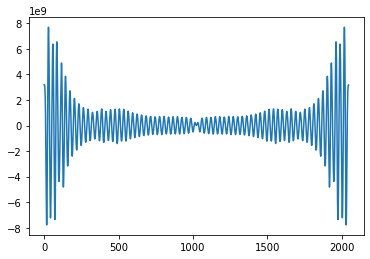

In [19]:
plt.plot(np.fft.fft(data[1]))

In [3]:
if not os.path.exists(in_dir):
    raise ValueError(f"Unknown model: {mod}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [4]:
def get_val(val):
    
    # Remove tailing comma
    if val.endswith(","):
        val = val[:-1]
    
    # Float / Int
    if val.isnumeric():
        
        if "." in val:
            return float(val)
        else:
            return int(val)
    
    # Bool
    if val in ["True", "False"]:
        return bool(val)
    
    # String
    if val.startswith("\""):
        return val.split("\"")[1]
    
    # List
    if val.startswith("["):
        
        vs = []
        for v in val.split("[")[1].split("]")[0].split(","):
            vs.append(get_val(v.strip()))
        return vs
    
    raise ValueError("Unknown data type")

In [5]:
# Get model architecture
with open(mod + ".py", "r") as F:
    lines = F.read().split("\n")

model_pars = {}
in_pars = False

# Parse script
for l in lines:
    
    # Identify model parameter block start
    if "model_pars = " in l:
        in_pars = True
    
    # Identify model parameter block end
    if l.strip() == ")":
        in_pars = False
    
    if in_pars:
        # Get line
        if "(" in l:
            L = l.split("(")[1].split("#")[0]
        else:
            L = l.strip().split("#")[0]
        
        key, val = L.split("=")
        
        v = get_val(val.strip())
        
        model_pars[key.strip()] = v

In [6]:
# Load loss and learning rate
all_lrs = np.load(in_dir + "all_lrs.npy")
all_losses = np.load(in_dir + "all_losses.npy")
all_val_losses = np.load(in_dir + "all_val_losses.npy")

n_chk = all_losses.shape[0]
best_chk = np.argmin(np.mean(all_val_losses, axis=1))
print(best_chk)

38


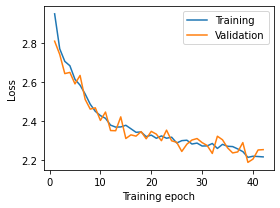

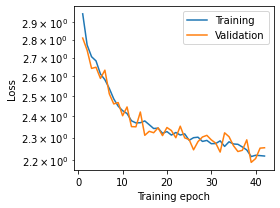

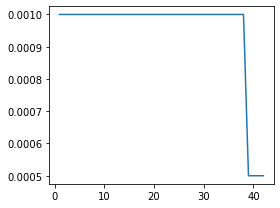

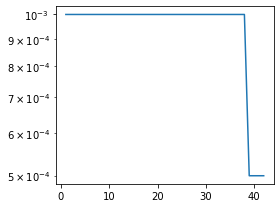

In [7]:
# Plot loss
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_chk+1), np.mean(all_losses, axis=1))
ax.plot(range(1, n_chk+1), np.mean(all_val_losses, axis=1))

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss.pdf")

plt.show()
plt.close()

# Plot loss, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_chk+1), np.mean(all_losses, axis=1))
ax.semilogy(range(1, n_chk+1), np.mean(all_val_losses, axis=1))

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss_log.pdf")

plt.show()
plt.close()

# Plot learning rate
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_chk+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs.pdf")

plt.show()
plt.close()

# Plot learning rate, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_chk+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs_log.pdf")

plt.show()
plt.close()

In [8]:
def plot_checkpoint(X, y_trg, y_std, y_pred, input_factor=5., show=True, save=None):
    
    if y_std is None:
        y_std = [[] for _ in range(X.shape[0])]
    
    n_pts = X.shape[-1]
    
    for i, (Xi, yi_trg, yi_std, yi_pred) in enumerate(zip(X, y_trg, y_std, y_pred)):
    
        # Print target vs. pred
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        ax.plot(yi_trg[0])
        ax.plot(yi_pred[0])
        
        if len(yi_std) > 0:
            ax.fill_between(range(n_pts), yi_pred[0] - yi_std[0], yi_pred[0] + yi_std[0], facecolor="C1", alpha=0.3)
        
        ax.legend(["Ground-truth", "Prediction"])
        
        if show:
            plt.show()
            
        if save is not None:
            plt.savefig(save + f"sample_{i+1}_pred.pdf")
            
        plt.close()
        
        # Print input and target
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        ax.plot(Xi[:, 0, :].T * input_factor)
        ax.plot(yi_trg[0], "r")
        
        ax.legend(["Ground-truth", "Prediction"])
        
        if show:
            plt.show()
            
        if save is not None:
            plt.savefig(save + f"sample_{i+1}_input.pdf")
            
        plt.close()
    
    return

# Evaluate the model history

In [9]:
if eval_history:

    fdir = fig_dir + "eval_history/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_chk):

        d = fdir + f"checkpoint_{i+1}/"
        if not os.path.exists(d):
            os.mkdir(d)

        X = np.load(in_dir + f"checkpoint_{i+1}_in.npy")
        y_trg = np.load(in_dir + f"checkpoint_{i+1}_trg.npy")
        y_pred = np.load(in_dir + f"checkpoint_{i+1}_pred.npy")
        y_std = np.load(in_dir + f"checkpoint_{i+1}_std.npy")

        plot_checkpoint(X, y_trg, y_std, y_pred, show=False, save=d)

# Load model and generate dataset

In [10]:
if eval_evolution or eval_sparse or eval_noise:

    net = model.ConvLSTMEnsemble(**model_pars)

    X = []
    y = []

    for i in range(n_samples):
        Xi, _, yi = dataset.__getitem__(0)
        X.append(Xi.unsqueeze(0))
        y.append(yi.unsqueeze(0))

    X = torch.cat(X, dim=0)
    y = torch.cat(y, dim=0)

In [11]:
if eval_evolution:

    fdir = fig_dir + "eval_evolution/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_chk):
        
        print(f"Checkpoint {i+1}/{n_chk}...")
        
        d = fdir + f"checkpoint_{i+1}/"
        if not os.path.exists(d):
            os.mkdir(d)
            
        print("  Loading model...")
        net.load_state_dict(torch.load(in_dir + f"checkpoint_{i+1}_network", map_location=torch.device("cpu")))
        net.eval()
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X)
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X, y, y_std, y_pred, show=False, save=d)
        
    print("All done!")

Checkpoint 1/42...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 2/42...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 3/42...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 4/42...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 5/42...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 6/42...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 7/42...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 8/42...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 9/42...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 10/42...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 11/42...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 12/42...
  Loading model...
  Performing predictions

In [12]:
if eval_sparse:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))

    fdir = fig_dir + "eval_sparse/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)
    
    # Lower MAS inputs
    print("Lower MAS range...")
    for i in range(model_pars["batch_input"], X.shape[1]+1):
        
        d = fdir + f"lower_{i}_rates/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X[:, :i])
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X, y, y_std, y_pred, show=False, save=d)
    
    # Higher MAS inputs
    print("Higher MAS range...")
    for i in range(model_pars["batch_input"], X.shape[1]+1):
        
        d = fdir + f"higher_{i}_rates/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X[:, -i:])
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X, y, y_std, y_pred, show=False, save=d)
        
    print("All done!")

Lower MAS range...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
Higher MAS range...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
All done!


In [13]:
if eval_noise:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))

    fdir = fig_dir + "eval_noise/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)
    
    for noise in noise_levels:
        
        print(f"Noise level {noise:.0e}...")
        
        d = fdir + f"noise_level_{noise:.0e}/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        # Generate noisy data
        X2 = X.clone() + (torch.randn(X.shape) * noise)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X2)
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X2, y, y_std, y_pred, show=False, save=d)
        
        print("Normalizing noisy spectra...")
        
        d = fdir + f"noise_level_{noise:.0e}_norm/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        vals_min, _ = torch.min(X2[:, :, 0], dim=-1)
        vals_min = torch.unsqueeze(vals_min, -1)
        X2[:, :, 0] -= vals_min
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X2)
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X2, y, y_std, y_pred, show=False, save=d)
    
    print("All done!")

Noise level 1e-04...
  Performing predictions...
  Plotting data...
Normalizing noisy spectra...
  Performing predictions...
  Plotting data...
Noise level 1e-03...
  Performing predictions...
  Plotting data...
Normalizing noisy spectra...
  Performing predictions...
  Plotting data...
Noise level 1e-02...
  Performing predictions...
  Plotting data...
Normalizing noisy spectra...
  Performing predictions...
  Plotting data...
Noise level 1e-01...
  Performing predictions...
  Plotting data...
Normalizing noisy spectra...
  Performing predictions...
  Plotting data...
All done!
